# ML Modeling Notebook

**Goal**: The aim of this notebook is to determine the best model with the lowest error.

**Output**: Best model for deployment.

**Table of Content**
- [1 Library](#1-Library)
- [2 Load Data](#2-Load-Data)
- [3 Preprocess](#3-Preprocess)
- [4 Benchmark Modeling](#4-Benchmark-Modeling)
- [5 Tweaking the Model](#5-Tweaking-the-Model)
    - [5.1 Feature Selection](#5.1-Feature-Selection)
    - [5.2 Hyperparameter Tuning](#5.2-Hyperparameter-Tuning)
- [6 Predict Test Data and Evaluate](#6-Predict-Test-Data-and-Evaluate)
- [5 Conclusion](#7-Conclusion)

<span style="color:red"> <strong>Warning: </strong> </span> Due to the large size of the data, running this notebook may take approximately 5 minutes.

___
# 1 Library

In [1]:
# Standard library
import pandas as pd
import numpy as np
import scipy.stats as scs
import joblib

# Visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling Library
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape
from sklearn.feature_selection import SelectFromModel
import pickle

import warnings 
warnings.filterwarnings('ignore')

# 2 Load Data

<span style="color:blue"> <strong>Must Read!</strong> </span>

The metadata can be seen in [this link](https://docs.google.com/spreadsheets/d/11lHi8CAf5iGoegEbtrQ7qPk9n2M6BQtzYLK9RLLqGmU/edit#gid=0).

In [2]:
# Load data
train_set = pd.read_csv('dataset/split/dataset_train.csv', index_col=0)
valid_set = pd.read_csv('dataset/split/dataset_test.csv', index_col=0)
test_set = pd.read_csv('dataset/split/dataset_valid.csv', index_col=0)

print(len(train_set), len(valid_set), len(test_set))

86604 53023 37116


In [3]:
# Filters housing unit only
housing = [1, 2, 3, 7, 8, 14]
train_set = train_set[train_set['category_id'].isin(housing)]
valid_set = valid_set[valid_set['category_id'].isin(housing)]
test_set = test_set[test_set['category_id'].isin(housing)]

print(len(train_set), len(valid_set), len(test_set))

82201 50390 35232


# 3 Preprocess

In [4]:
# Create function to remove outliers
def remove_outliers(set_data):
    num_col = set_data.select_dtypes(include=['int64', 'float64']).columns.to_list()
    
    list_of_set_data = list()

    for col_name in num_col:
        q1 = set_data[col_name].quantile(0.1)
        q3 = set_data[col_name].quantile(0.9)
        iqr = q3 - q1
        set_data = set_data[~((set_data[col_name] < (q1 - 1.5 * iqr))
                            | (set_data[col_name] > (q3 + 1.5 * iqr)))].copy()

    return set_data

In [5]:
# # Remove outliers on train, valid, and test data
# train_set = remove_outliers(train_set)
# valid_set = remove_outliers(valid_set)
# test_set = remove_outliers(test_set)
# print(len(train_set))
# print(len(valid_set))
# print(len(test_set))

In [6]:
# Split to X y and Drop irrelevant column for modelling
X_train = train_set.drop(columns = ['address', 'zip_code', 'borough_name', 'borough',
                                    'block', 'lot', 'latitude', 'longitude', 'geometry', 
                                    'category_id', 'building_class_name', 'sale_date', 'sale_price'])
y_train = train_set['sale_price']

X_valid = valid_set.drop(columns = ['address', 'zip_code', 'borough_name', 'borough',
                                    'block', 'lot', 'latitude', 'longitude', 'geometry', 
                                    'category_id', 'building_class_name', 'sale_date', 'sale_price'])
y_valid = valid_set['sale_price']

X_test = test_set.drop(columns = ['address', 'zip_code', 'borough_name', 'borough',
                                  'block', 'lot', 'latitude', 'longitude', 'geometry', 
                                  'category_id', 'building_class_name', 'sale_date', 'sale_price'])
y_test = test_set['sale_price']

print(len(X_train), len(y_train), len(X_valid), len(y_valid), len(X_test), len(y_test))

82201 82201 50390 50390 35232 35232


In [36]:
X_train.columns

Index(['building_class_category', 'gross_square_feet', 'year_built',
       'subway_count_in_1km', 'bus_count_in_1km', 'schools_count_in_1km',
       'health_facil_count_in_1km', 'park_properties_count_in_1km',
       'park_zones_count_in_1km'],
      dtype='object')

In [7]:
# Scaling
scaler = StandardScaler()
scaler.fit(X_train.drop(columns=['building_class_category']))
scaled = scaler.transform(X_train.drop(columns=['building_class_category']))
scaled

array([[-0.12970732, -1.36575996,  0.25222716, ..., -0.77715265,
        -0.53963136,  0.3701601 ],
       [-0.29065076,  0.37440748, -0.65238569, ..., -0.52194077,
        -0.75413739, -0.74854023],
       [-0.14745844,  0.88622144, -0.65238569, ..., -0.9047586 ,
        -0.32512534,  0.3701601 ],
       ...,
       [-0.20860117, -0.13740647, -0.65238569, ..., -0.77715265,
        -0.64688438, -0.74854023],
       [-0.2543596 , -0.30801112, -0.65238569, ..., -0.77715265,
        -0.75413739, -0.74854023],
       [-0.22911357,  0.54501213, -0.149823  , ...,  0.24369489,
        -0.64688438, -0.3010601 ]])

In [8]:
# Display data
train_scaled = pd.DataFrame(scaled, columns=X_train.drop(columns=['building_class_category']).columns)
train_scaled.index = X_train.index
train_scaled

,gross_square_feet,year_built,subway_count_in_1km,bus_count_in_1km,schools_count_in_1km,health_facil_count_in_1km,park_properties_count_in_1km,park_zones_count_in_1km
128157,-0.129707,-1.365760,0.252227,0.114231,-0.612665,-0.777153,-0.539631,0.37016
158906,-0.290651,0.374407,-0.652386,-0.581923,-0.903838,-0.521941,-0.754137,-0.74854
144731,-0.147458,0.886221,-0.652386,-0.581923,-0.806780,-0.904759,-0.325125,0.37016
89241,-0.143908,1.705124,-0.652386,-0.283571,-0.903838,-0.904759,-0.325125,-0.74854
48772,-0.080596,1.227431,0.352740,0.213682,0.357913,-0.266729,0.425646,-0.52480
...,...,...,...,...,...,...,...,...
6525,0.147210,-0.308011,-0.049310,0.512033,-0.030318,-0.139123,0.961911,0.81764
94820,-0.365008,-1.297518,-0.451361,-0.880274,-1.195012,-0.777153,-0.861390,-0.30106
183653,-0.208601,-0.137406,-0.652386,-0.184120,-0.321491,-0.777153,-0.646884,-0.74854
113299,-0.254360,-0.308011,-0.652386,-0.581923,-0.709723,-0.777153,-0.754137,-0.74854


In [9]:
# Transform and Display data
scaled_val = scaler.transform(X_valid.drop(columns=['building_class_category']))
scaled_ts = scaler.transform(X_test.drop(columns=['building_class_category']))

valid_scaled = pd.DataFrame(scaled_val, columns=X_valid.drop(columns=['building_class_category']).columns)
test_scaled = pd.DataFrame(scaled_ts, columns=X_valid.drop(columns=['building_class_category']).columns)

valid_scaled.index = X_valid.index
test_scaled.index = X_test.index

valid_scaled

,gross_square_feet,year_built,subway_count_in_1km,bus_count_in_1km,schools_count_in_1km,health_facil_count_in_1km,park_properties_count_in_1km,park_zones_count_in_1km
11815,0.097507,-1.161034,0.553765,0.114231,0.066740,2.157784,-0.539631,-0.52480
95103,-0.246470,-0.990430,-0.451361,-0.681373,0.163798,-0.139123,-0.325125,-0.74854
100313,-0.216096,-1.161034,-0.049310,0.014781,0.163798,1.774966,-0.432378,0.14642
114578,-0.282761,-0.308011,-0.652386,-0.880274,-0.709723,-0.394335,-0.539631,-0.74854
137772,-0.302485,-0.308011,-0.551873,-0.880274,-1.195012,-0.139123,-0.110619,0.37016
...,...,...,...,...,...,...,...,...
180446,-0.229114,-0.649220,-0.652386,-0.283571,-0.806780,-0.011517,-0.217872,0.14642
139364,-0.300118,0.033198,-0.652386,0.114231,-0.127376,-0.649547,-0.754137,-0.74854
7893,0.109341,-0.308011,1.558890,1.407088,0.163798,0.881725,3.214224,-0.52480
120083,-0.355344,1.773366,-0.250336,-0.681373,-1.195012,-1.032365,-0.754137,-0.74854


In [10]:
# # Categorical features encoding
# le = LabelEncoder()

# le.fit(X_train['building_class_category'])
# train_scaled['building_class_category'] = le.transform(X_train['building_class_category'])

# valid_scaled['building_class_category'] = le.transform(X_valid['building_class_category'])
# test_scaled['building_class_category'] = le.transform(X_test['building_class_category'])

In [11]:
# One Hot Encoding/Get dummies
train_ohe = pd.get_dummies(X_train['building_class_category'], dtype=int)
valid_ohe = pd.get_dummies(X_valid['building_class_category'], dtype=int)
test_ohe = pd.get_dummies(X_test['building_class_category'], dtype=int)

In [12]:
# Concat Scaled Numerical Data with OHE
train_eng = pd.concat([train_scaled, train_ohe], axis=1)
valid_eng = pd.concat([valid_scaled, valid_ohe], axis=1)
test_eng = pd.concat([test_scaled, test_ohe], axis=1)

In [13]:
# Display data
train_eng

,gross_square_feet,year_built,subway_count_in_1km,bus_count_in_1km,schools_count_in_1km,health_facil_count_in_1km,park_properties_count_in_1km,park_zones_count_in_1km,01 ONE FAMILY DWELLINGS,02 TWO FAMILY DWELLINGS,03 THREE FAMILY DWELLINGS,07 RENTALS - WALKUP APARTMENTS,08 RENTALS - ELEVATOR APARTMENTS,14 RENTALS - 4-10 UNIT
128157,-0.129707,-1.365760,0.252227,0.114231,-0.612665,-0.777153,-0.539631,0.37016,0,1,0,0,0,0
158906,-0.290651,0.374407,-0.652386,-0.581923,-0.903838,-0.521941,-0.754137,-0.74854,1,0,0,0,0,0
144731,-0.147458,0.886221,-0.652386,-0.581923,-0.806780,-0.904759,-0.325125,0.37016,0,1,0,0,0,0
89241,-0.143908,1.705124,-0.652386,-0.283571,-0.903838,-0.904759,-0.325125,-0.74854,0,0,1,0,0,0
48772,-0.080596,1.227431,0.352740,0.213682,0.357913,-0.266729,0.425646,-0.52480,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6525,0.147210,-0.308011,-0.049310,0.512033,-0.030318,-0.139123,0.961911,0.81764,0,0,0,1,0,0
94820,-0.365008,-1.297518,-0.451361,-0.880274,-1.195012,-0.777153,-0.861390,-0.30106,1,0,0,0,0,0
183653,-0.208601,-0.137406,-0.652386,-0.184120,-0.321491,-0.777153,-0.646884,-0.74854,1,0,0,0,0,0
113299,-0.254360,-0.308011,-0.652386,-0.581923,-0.709723,-0.777153,-0.754137,-0.74854,1,0,0,0,0,0


# 4 Benchmark Modeling

In [14]:
# Model assignment
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
xgb = XGBRegressor()

models = [lr, dt, rf, xgb]

In [15]:
# Fit and evaluation
tr_score = []
val_score = []
tr_rmse = []
val_rmse = []
tr_mape = []
val_mape = []
tr_mae = []
val_mae = []

for regressor in models:
    regressor.fit(train_eng, y_train)

    y_train_pred = regressor.predict(train_eng) 
    y_valid_pred = regressor.predict(valid_eng) 
    
    tr_score.append(r2_score(y_train, y_train_pred))
    val_score.append(r2_score(y_valid, y_valid_pred))
    tr_rmse.append(np.sqrt(mse(y_train, y_train_pred)))
    val_rmse.append(np.sqrt(mse(y_valid, y_valid_pred)))
    tr_mape.append(mape(y_train, y_train_pred))
    val_mape.append(mape(y_valid, y_valid_pred))
    tr_mae.append(mae(y_train, y_train_pred))
    val_mae.append(mae(y_valid, y_valid_pred))


In [16]:
df_eval = pd.DataFrame({
    'Train R2 Score':tr_score, 'Valid R2 Score':val_score,
    'Train RMSE':tr_rmse, 'Valid RMSE':val_rmse,
    'Train MAPE':tr_mape, 'Valid MAPE':val_mape,
    'Train MAE':tr_mae, 'Valid MAE':val_mae, 
})

df_eval.index = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'XGBRegressor']
df_eval

,Train R2 Score,Valid R2 Score,Train RMSE,Valid RMSE,Train MAPE,Valid MAPE,Train MAE,Valid MAE
LinearRegression,0.407670,0.427538,2.232854e+06,2.016524e+06,1.367007,1.240148,657249.728474,646509.816885
DecisionTreeRegressor,0.983526,0.328640,3.723696e+05,2.183776e+06,0.105563,0.829772,40712.454319,562571.020324
RandomForestRegressor,0.926049,0.603168,7.889520e+05,1.678934e+06,0.354704,0.777577,182756.647582,435410.132840
XGBRegressor,0.904018,0.555254,8.988233e+05,1.777404e+06,0.884742,0.912936,364246.405283,474335.293125


# 5 Tweaking the Model

## 5.1 Feature Selection

In [17]:
RandomForestRegressor()

RandomForestRegressor()

In [18]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 100))
sel.fit(train_eng, y_train)

SelectFromModel(estimator=RandomForestRegressor())

In [19]:
# Get the name of the features selected
selected_feat = train_eng.columns[(sel.get_support())]
print(selected_feat)

Index(['gross_square_feet', 'year_built', 'subway_count_in_1km',
       'schools_count_in_1km', 'park_zones_count_in_1km'],
      dtype='object')


gross_square_feet                   0.433404
subway_count_in_1km                 0.116432
park_zones_count_in_1km             0.091657
year_built                          0.088129
park_properties_count_in_1km        0.072532
schools_count_in_1km                0.069935
health_facil_count_in_1km           0.050157
bus_count_in_1km                    0.048228
07 RENTALS - WALKUP APARTMENTS      0.012749
01 ONE FAMILY DWELLINGS             0.007384
08 RENTALS - ELEVATOR APARTMENTS    0.005568
02 TWO FAMILY DWELLINGS             0.001520
14 RENTALS - 4-10 UNIT              0.001445
03 THREE FAMILY DWELLINGS           0.000862
dtype: float64


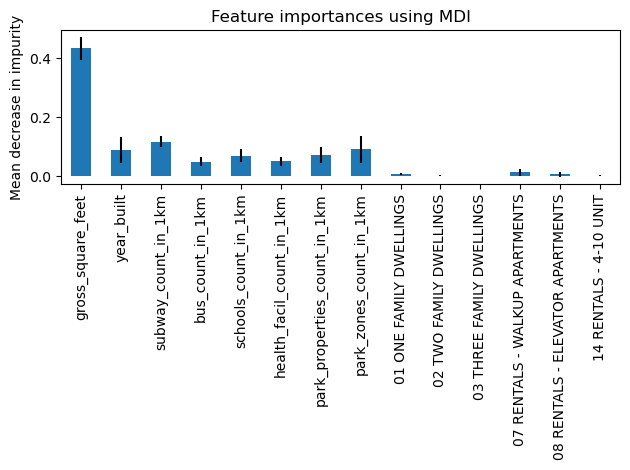

In [20]:
# Feature importance
feature_names = train_eng.columns
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

print(forest_importances.sort_values(ascending=False))

## 5.2 Hyperparameter Tuning

In [21]:
selected_features = ['gross_square_feet', 'year_built', 'subway_count_in_1km', 
                     'schools_count_in_1km', 'park_zones_count_in_1km']

In [22]:
hyperparam_rf = {
    "n_estimators": [100, 200, 300],
    "min_samples_split":  [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

In [23]:
skf = StratifiedKFold(n_splits=3)

rf_grid = GridSearchCV(rf, param_grid=hyperparam_rf, scoring='neg_median_absolute_error', cv=skf, verbose=1, n_jobs=-1)
rf_grid.fit(train_eng[selected_features], y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_median_absolute_error', verbose=1)

In [24]:
rf_grid.best_params_

{'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}

In [25]:
rf_tuned = rf_grid.best_estimator_

In [26]:
# Fit and evaluate tuned RF to the selected features
rf_tuned.fit(train_eng[selected_features], y_train)
y_pred_rf_tuned_tr = rf_tuned.predict(train_eng[selected_features])

print(r2_score(y_train, y_pred_rf_tuned_tr))
print(np.sqrt(mse(y_train, y_pred_rf_tuned_tr)))
print(mape(y_train, y_pred_rf_tuned_tr))
print(mae(y_train, y_pred_rf_tuned_tr))

0.7500813043457906
1450366.8886798588
0.6547550379723925
330113.4259302001


In [27]:
# Fit and evaluate tuned RF to the original features
rf_tuned.fit(train_eng, y_train)
y_pred_rf_tuned_tr = rf_tuned.predict(train_eng)

print(r2_score(y_train, y_pred_rf_tuned_tr))
print(np.sqrt(mse(y_train, y_pred_rf_tuned_tr)))
print(mape(y_train, y_pred_rf_tuned_tr))
print(mae(y_train, y_pred_rf_tuned_tr))

0.7772946528754444
1369127.2862420937
0.5768390890183176
286756.6261322414


In [28]:
# Fit and evaluate benchmark RF to the selected features
rf.fit(train_eng[selected_features], y_train)
y_pred_rf_tuned_tr = rf.predict(train_eng[selected_features])

print(r2_score(y_train, y_pred_rf_tuned_tr))
print(np.sqrt(mse(y_train, y_pred_rf_tuned_tr)))
print(mape(y_train, y_pred_rf_tuned_tr))
print(mae(y_train, y_pred_rf_tuned_tr))

0.923125206371843
804397.0793893524
0.3946504597681455
202480.9944717206


In [29]:
# Fit and evaluate benchmark RF to the original features
rf.fit(train_eng, y_train)
y_pred_rf_tuned_tr = rf.predict(train_eng)

print(r2_score(y_train, y_pred_rf_tuned_tr))
print(np.sqrt(mse(y_train, y_pred_rf_tuned_tr)))
print(mape(y_train, y_pred_rf_tuned_tr))
print(mae(y_train, y_pred_rf_tuned_tr))

0.9220915073811468
809787.1938513742
0.3572233659667851
182598.4479128543


# 6 Predict Test Data and Evaluate

In [30]:
rf_tuned.fit(train_eng[selected_features], y_train)
y_pred_rf_tuned_ts = rf_tuned.predict(test_eng[selected_features])

In [31]:
print(r2_score(y_test, y_pred_rf_tuned_ts))
print(np.sqrt(mse(y_test, y_pred_rf_tuned_ts)))
print(mape(y_test, y_pred_rf_tuned_ts))
print(mae(y_test, y_pred_rf_tuned_ts))

0.5394107522821621
1774504.1767629767
0.926333248053777
454788.704017477


In [32]:
rf.fit(train_eng, y_train)
y_pred_rf_ts = rf.predict(test_eng)

In [33]:
print(r2_score(y_test, y_pred_rf_ts))
print(np.sqrt(mse(y_test, y_pred_rf_ts)))
print(mape(y_test, y_pred_rf_ts))
print(mae(y_test, y_pred_rf_ts))

0.5828085602762372
1688837.3398799591
0.8127432154670662
417616.238763725


It seems like the default RandomForestRegressor using all features outperform the tuned one. So, this model will be chosen for deployment.

# 7 Save Model

In [34]:
# Combine all data
X = pd.concat([train_eng, valid_eng, test_eng])
y = pd.concat([y_train, y_valid, y_test] )

In [35]:
# Fit all data and pickle save
best_model = rf
best_model.fit(X,y)
model_file_name = 'model/rf_model_20230119.sav'
pickle.dump(best_model, open(model_file_name, 'wb'))